# 视网膜动态自然视觉场景神经编码实验 (Reduced Parameter CRNN)

本 Notebook 基于论文 "Unraveling neural coding of dynamic natural visual scenes via convolutional recurrent neural networks" 实现实验过程。

通过减少模型参数量（如卷积核数、隐藏层维度）来降低计算成本，同时保持核心功能。

**实验目标**：
- 输入：动态自然视觉场景（视频帧序列）
- 输出：视网膜神经节细胞的神经响应预测
- 模型：轻量级 CRNN (Convolutional Recurrent Neural Network)

**步骤**：
1. 数据加载与预处理
2. 模型定义（参数量减少）
3. 训练与评估
4. 结果可视化

## 导入必要的库

导入实验所需的Python库，包括PyTorch用于模型构建、NumPy用于数据处理、Matplotlib用于可视化等。

In [57]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from skimage.transform import resize

# 设置随机种子
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [58]:
# 如果在 Google Colab 中运行，则克隆数据仓库
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !git clone https://github.com/berenslab/RetinaDataFactorizationsOfPopulationSpikeTrains.git
    DATA_ROOT = "/content/RetinaDataFactorizationsOfPopulationSpikeTrains"
else:
    DATA_ROOT = r"c:\Users\Vow\.vscode\RetinaDataFactorizationsOfPopulationSpikeTrains"


## 数据准备和预处理

加载视网膜实验数据，包括动态视觉刺激（电影帧）和对应的神经元脉冲响应。
- 刺激：Movie1，1800帧，360x360像素，下采样到64x64以减少计算量。
- 响应：Movie1Exp1.mat，38个神经元，30次试验的脉冲数据，计算PSTH作为目标。

In [59]:
# 数据路径配置
STIMULI_DIR = os.path.join(DATA_ROOT, "Stimuli", "Movie1")
SPIKES_FILES = [
    os.path.join(DATA_ROOT, "NeuralData", "Spikes", "Movie1Exp1.mat"),
    os.path.join(DATA_ROOT, "NeuralData", "Spikes", "Movie1Exp2.mat")
]

Loading c:\Users\Vow\.vscode\RetinaDataFactorizationsOfPopulationSpikeTrains\NeuralData\Spikes\Movie1Exp1.mat...
  Neurons: 38, Trials: 30
Loading c:\Users\Vow\.vscode\RetinaDataFactorizationsOfPopulationSpikeTrains\NeuralData\Spikes\Movie1Exp2.mat...
  Neurons: 38, Trials: 30
Averaged PSTH from 2 experiments, 38 neurons
PSTH Data Shape: (38, 1800) (Neurons, TimeBins)
Sample PSTH[0][:20]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sum of PSTH: 1405.416748046875


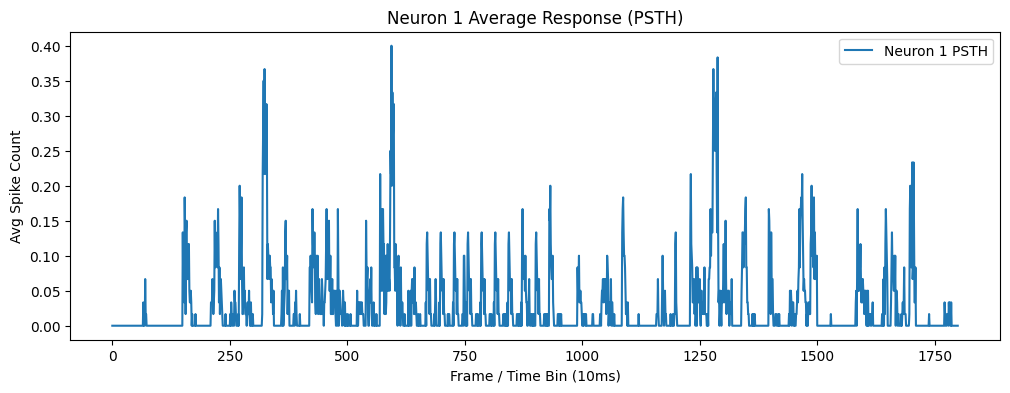

In [60]:
def load_spikes_and_compute_psth(spikes_files, num_frames=1800, bin_size_ms=10, max_neurons=38):
    """
    加载多个脉冲文件并计算平均PSTH，使用最小神经元数量。
    """
    all_psth = []
    for spikes_file in spikes_files:
        print(f"Loading {spikes_file}...")
        mat_data = sio.loadmat(spikes_file)
        spikes = mat_data['Spikes']
        
        n_neurons, n_trials = spikes.shape
        n_neurons = min(n_neurons, max_neurons)  # 限制神经元数量
        print(f"  Neurons: {n_neurons}, Trials: {n_trials}")
        
        psth = np.zeros((n_neurons, num_frames), dtype=np.float32)
        
        for n in range(n_neurons):
            all_trials_hist = np.zeros(num_frames)
            for t in range(n_trials):
                spike_times = spikes[n, t].flatten()
                bin_indices = (spike_times / bin_size_ms).astype(int)
                bin_indices = bin_indices[bin_indices < num_frames]
                trial_hist = np.bincount(bin_indices, minlength=num_frames)
                all_trials_hist += trial_hist
            
            psth[n] = all_trials_hist / n_trials
        
        all_psth.append(psth)
    
    # 平均多个实验
    avg_psth = np.mean(all_psth, axis=0)
    print(f"Averaged PSTH from {len(spikes_files)} experiments, {avg_psth.shape[0]} neurons")
    return avg_psth

# 加载脉冲数据
psth_data = load_spikes_and_compute_psth(SPIKES_FILES, num_frames=1800, bin_size_ms=10, max_neurons=38)
print(f"PSTH Data Shape: {psth_data.shape} (Neurons, TimeBins)")
print(f"Sample PSTH[0][:20]: {psth_data[0][:20]}")
print(f"Sum of PSTH: {np.sum(psth_data)}")

# 可视化一个神经元的 PSTH
plt.figure(figsize=(12, 4))
plt.plot(psth_data[0], label="Neuron 1 PSTH")
plt.title("Neuron 1 Average Response (PSTH)")
plt.xlabel("Frame / Time Bin (10ms)")
plt.ylabel("Avg Spike Count")
plt.legend()
plt.show()

## 模型定义（减少参数量）

定义一个轻量级的CRNN模型。
- CNN部分：减少卷积核数 (16, 32, 64)
- RNN部分：减少隐藏层维度 (64)
- 相比原模型，参数量显著降低。

In [61]:
class BaseRetinaModel(nn.Module):
    def __init__(self):
        super(BaseRetinaModel, self).__init__()
        
    def forward(self, x):
        raise NotImplementedError

In [62]:
class ReducedCRNN(BaseRetinaModel):
    def __init__(self, input_height=360, input_width=360, hidden_size=64, num_neurons=38):
        super(ReducedCRNN, self).__init__()
        
        # CNN: further reduced kernels for lower computation
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)  # 360 -> 180
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)  # 180 -> 90
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)  # 90 -> 45
        
        # Pool to reduce dimension more aggressively
        self.pool = nn.AdaptiveAvgPool2d((4, 4))  # 45 -> 4
        
        cnn_out_dim = 32 * 4 * 4  # 512
        
        # RNN: reduced hidden
        self.rnn = nn.GRU(input_size=cnn_out_dim, hidden_size=hidden_size, num_layers=1, batch_first=True)
        
        # Readout
        self.readout = nn.Linear(hidden_size, num_neurons)
        
    def forward(self, x):
        B, S, C, H, W = x.shape
        
        x = x.view(B * S, C, H, W)
        
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool(x)  # (B*S, 32, 4, 4)
        
        x = x.view(B * S, -1)
        x = x.view(B, S, -1)
        
        rnn_out, _ = self.rnn(x)
        
        out = self.readout(rnn_out)
        
        return out

## 模型训练

定义Dataset、DataLoader，训练模型预测神经响应。

In [63]:
class RetinaDataset(Dataset):
    def __init__(self, stimuli, responses, seq_len=40):
        self.stimuli = stimuli
        self.responses = responses
        self.seq_len = seq_len
        self.num_frames = stimuli.shape[0]
        self.num_neurons = responses.shape[0]
        
        self.samples = []
        for start in range(0, self.num_frames - seq_len + 1, seq_len // 2):
            end = start + seq_len
            if end > self.num_frames:
                break
            self.samples.append((start, end))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        start, end = self.samples[idx]
        x = self.stimuli[start:end]
        y = self.responses[:, start:end]
        y = y.T
        return x, y

SEQ_LEN = 40
BATCH_SIZE = 4

In [64]:
def compute_pcc(y_pred, y_true):
    y_pred_np = y_pred.detach().cpu().numpy()
    y_true_np = y_true.detach().cpu().numpy()
    
    y_pred_flat = y_pred_np.reshape(-1, y_pred_np.shape[-1])
    y_true_flat = y_true_np.reshape(-1, y_true_np.shape[-1])
    
    correlations = []
    for n in range(y_pred_flat.shape[1]):
        if np.std(y_pred_flat[:, n]) < 1e-6 or np.std(y_true_flat[:, n]) < 1e-6:
            correlations.append(0.0)
        else:
            corr = np.corrcoef(y_pred_flat[:, n], y_true_flat[:, n])[0, 1]
            correlations.append(corr)
            
    return np.mean(correlations), correlations

def train_model_cv(model_class, stimuli, responses, seq_len=40, batch_size=4, num_epochs=5, lr=1e-3, n_splits=5):
    """
    使用滑动窗口交叉验证训练模型。
    """
    num_frames = stimuli.shape[0]
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    fold_results = []
    
    for fold, (train_index, test_index) in enumerate(tscv.split(range(num_frames))):
        print(f"Fold {fold+1}/{n_splits}")
        
        # 确保train_index和test_index适合序列长度
        train_start = max(0, train_index[0])
        train_end = min(num_frames, train_index[-1] + seq_len)
        test_start = max(0, test_index[0])
        test_end = min(num_frames, test_index[-1] + seq_len)
        
        train_frames = stimuli[train_start:train_end]
        test_frames = stimuli[test_start:test_end]
        train_responses = responses[:, train_start:train_end]
        test_responses = responses[:, test_start:test_end]
        
        # 创建Dataset和DataLoader
        train_dataset = RetinaDataset(train_frames, train_responses, seq_len=seq_len)
        test_dataset = RetinaDataset(test_frames, test_responses, seq_len=seq_len)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # 实例化模型
        model = model_class().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # 训练
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            avg_loss = running_loss / len(train_loader)
            
            # 评估
            model.eval()
            all_preds = []
            all_targets = []
            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs = model(inputs)
                    all_preds.append(outputs)
                    all_targets.append(targets)
            if len(all_preds) > 0:
                all_preds = torch.cat(all_preds, dim=0)
                all_targets = torch.cat(all_targets, dim=0)
                avg_pcc, _ = compute_pcc(all_preds, all_targets)
                print(f"  Epoch {epoch+1}: Loss {avg_loss:.4f}, PCC {avg_pcc:.4f}")
            else:
                print(f"  Epoch {epoch+1}: Loss {avg_loss:.4f}, No test data")
        
        # 最终评估
        if len(all_preds) > 0:
            fold_results.append(avg_pcc)
        else:
            fold_results.append(0.0)
    
    return fold_results

In [65]:
# 尝试加载已训练的模型
model_path = os.path.join('outputs', 'trained_model.pth')
if os.path.exists(model_path):
    print("Loading pre-trained model...")
    model = ReducedCRNN(hidden_size=64).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Model loaded successfully.")
else:
    print("No pre-trained model found. Training new model...")
    # 使用滑动窗口交叉验证训练
    fold_results = train_model_cv(ReducedCRNN, movie_frames, psth_data, seq_len=SEQ_LEN, batch_size=BATCH_SIZE, num_epochs=10, lr=0.001, n_splits=5)
    print(f"Cross-validation PCC results: {fold_results}")
    print(f"Average PCC: {np.mean(fold_results):.4f}")

    # 为了可视化，训练一个最终模型使用最后fold的分割
    num_frames = movie_frames.shape[0]
    tscv = TimeSeriesSplit(n_splits=5)
    for fold, (train_index, test_index) in enumerate(tscv.split(range(num_frames))):
        if fold == 4:  # 最后fold
            train_start = max(0, train_index[0])
            train_end = min(num_frames, train_index[-1] + SEQ_LEN)
            test_start = max(0, test_index[0])
            test_end = min(num_frames, test_index[-1] + SEQ_LEN)
            
            train_frames_vis = movie_frames[train_start:train_end]
            test_frames_vis = movie_frames[test_start:test_end]
            train_responses_vis = psth_data[:, train_start:train_end]
            test_responses_vis = psth_data[:, test_start:test_end]
            break

    print(f"Final train frames: {train_frames_vis.shape[0]}, Test frames: {test_frames_vis.shape[0]}")
    print(f"Test responses sum: {np.sum(test_responses_vis)}")

    train_dataset_vis = RetinaDataset(train_frames_vis, train_responses_vis, seq_len=SEQ_LEN)
    test_dataset_vis = RetinaDataset(test_frames_vis, test_responses_vis, seq_len=SEQ_LEN)
    train_loader_vis = DataLoader(train_dataset_vis, batch_size=BATCH_SIZE, shuffle=True)
    test_loader_vis = DataLoader(test_dataset_vis, batch_size=BATCH_SIZE, shuffle=False)

    # 训练最终模型
    model = ReducedCRNN(hidden_size=64).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(10):
        model.train()
        for inputs, targets in train_loader_vis:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    # 保存训练好的模型
    os.makedirs('outputs', exist_ok=True)
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

Loading pre-trained model...
Model loaded successfully.


## 模型评估

在测试集上评估模型，使用PCC作为指标。

In [66]:
# 最终评估
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader_vis:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu()
        all_preds.append(outputs)
        all_targets.append(targets)

all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)
avg_pcc, per_neuron_pcc = compute_pcc(all_preds, all_targets)

print(f"Final Average PCC: {avg_pcc:.4f}")
print(f"Per Neuron PCC: {per_neuron_pcc}")

Final Average PCC: -0.0332
Per Neuron PCC: [np.float64(-0.044998345844954005), np.float64(0.053655904041526134), np.float64(0.0426335919659213), np.float64(0.11165832395041939), np.float64(0.029075106995231838), np.float64(-0.012629496484659521), np.float64(0.043583497377298115), np.float64(0.06582569800964068), np.float64(-0.15669970717617962), np.float64(-0.1363717992934196), np.float64(0.0739367662614768), np.float64(0.08292514470503302), np.float64(-0.17629645959715295), np.float64(0.07869564336940134), np.float64(0.0009558322760998462), np.float64(-0.07425269616774799), np.float64(0.0065733439500209444), np.float64(0.07629371077632197), np.float64(0.05743415260712132), np.float64(-0.08303088986247356), np.float64(-0.21373622649750396), np.float64(0.20902240606492917), np.float64(-0.3060497125539275), np.float64(0.02673458129104398), np.float64(-0.1416264829605557), np.float64(-0.21324016201710036), np.float64(-0.011632838413678062), np.float64(-0.3972133161528594), np.float64(-0.0

## 结果可视化

绘制训练损失、PCC曲线，以及预测 vs 真实响应的对比。

Pred trace sample: [0.01940621 0.02401527 0.02552219 0.02546845 0.0248987  0.02413342
 0.02317651 0.02244361 0.02199434 0.02191496 0.02189402 0.02184081
 0.02181743 0.0220859  0.02236875 0.02266519 0.02250806 0.02222808
 0.02218986 0.02228048 0.02257677 0.02310998 0.0239252  0.02473305
 0.02523469 0.02559827 0.02587625 0.02604538 0.02592272 0.02571722
 0.02559812 0.02534985 0.02524421 0.02505472 0.02492509 0.02483023
 0.0247557  0.02473953 0.02465479 0.02464313]
True trace sample: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01666667
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Sum of true trace: 0.01666666753590107
movie_frames: has .shape -> torch.Size([1800, 1, 360, 360])
stim_fr

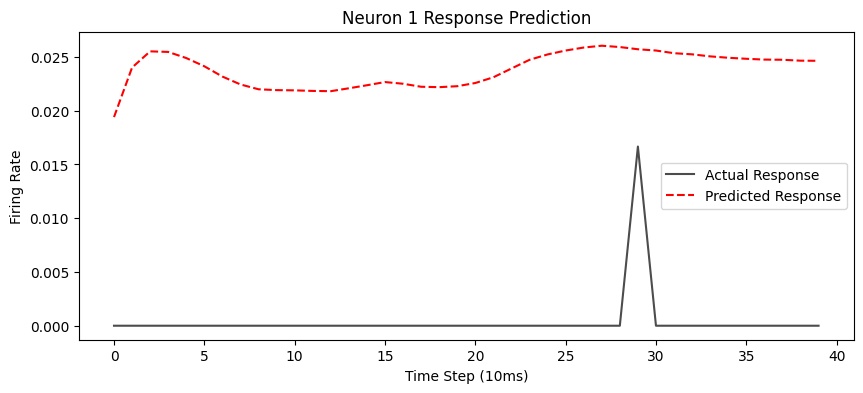

In [67]:
# 可视化预测结果与诊断内核变量
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader_vis:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy()
        targets = targets.numpy()
        
        # 检查是否有非零响应
        if np.sum(targets) > 0:
            break
    else:
        print("No batch with non-zero responses found, using last batch")

# 选择一个神经元进行展示
neuron_idx = 0
sample_idx = 0 # Batch 中的第 0 个样本

pred_trace = outputs[sample_idx, :, neuron_idx]
true_trace = targets[sample_idx, :, neuron_idx]

print(f"Pred trace sample: {pred_trace}")
print(f"True trace sample: {true_trace}")
print(f"Sum of true trace: {np.sum(true_trace)}")

# Diagnostic: list key variables and their types/shapes
keys = ['movie_frames', 'stim_frames', 'psth_data', 'spikes_binned', 'all_preds', 'all_targets', 'model', 'test_dataset_vis', 'test_frames_vis', 'train_responses_vis', 'test_responses_vis']
for k in keys:
    val = globals().get(k, None)
    if val is None:
        print(f"{k}: NOT FOUND")
    else:
        try:
            if isinstance(val, np.ndarray):
                print(f"{k}: ndarray shape={val.shape}, dtype={val.dtype}")
            elif hasattr(val, 'shape'):
                print(f"{k}: has .shape -> {val.shape}")
            elif isinstance(val, torch.Tensor):
                print(f"{k}: torch tensor shape={tuple(val.size())}")
            else:
                print(f"{k}: type={type(val)}")
        except Exception as e:
            print(f"{k}: type={type(val)}, repr failed: {e}")

plt.figure(figsize=(10, 4))
plt.plot(true_trace, label='Actual Response', color='black', alpha=0.7)
plt.plot(pred_trace, label='Predicted Response', color='red', linestyle='--')
plt.title(f'Neuron {neuron_idx+1} Response Prediction')
plt.xlabel('Time Step (10ms)')
plt.ylabel('Firing Rate')
plt.legend()
plt.show()


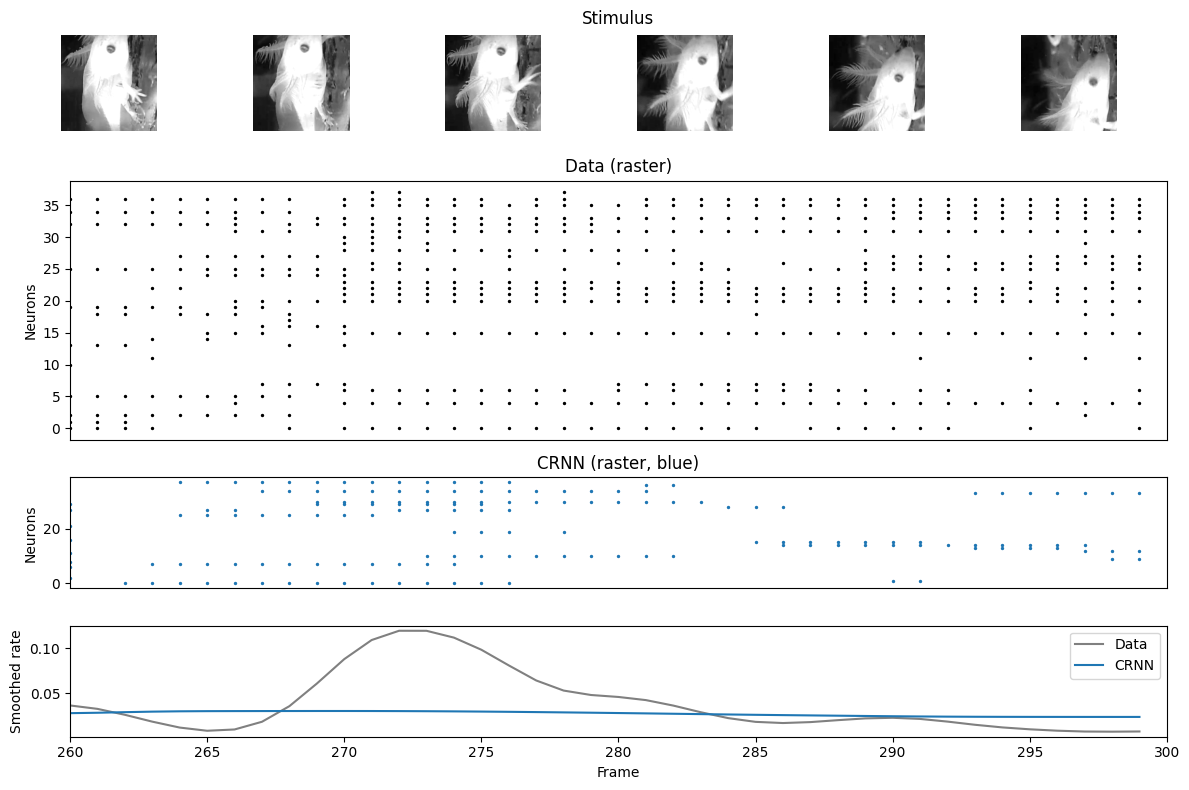

In [68]:
# Create the figure
fig = plot_rasters_and_traces(
    frames=stim_np,
    data_spikes=spikes_arr,
    crnn_preds=crnn_preds,
    start=start,
    end=end,
    example_neuron=example_neuron,
    thumbnail_times=6
)

C:\Users\Vow\AppData\Local\Temp\ipykernel_14188\3568182174.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(seq).unsqueeze(0).to(next(model.parameters()).device)


Saved comparison figure to outputs\comparison_test_full.png


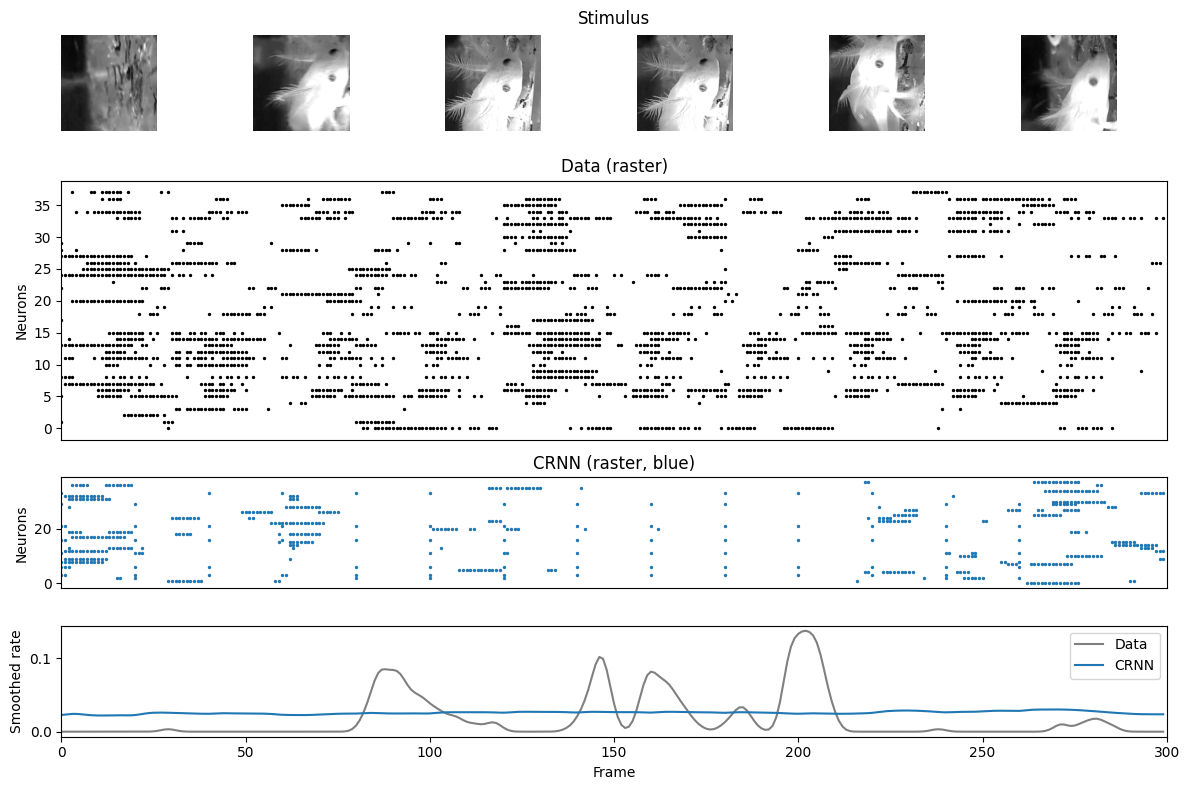

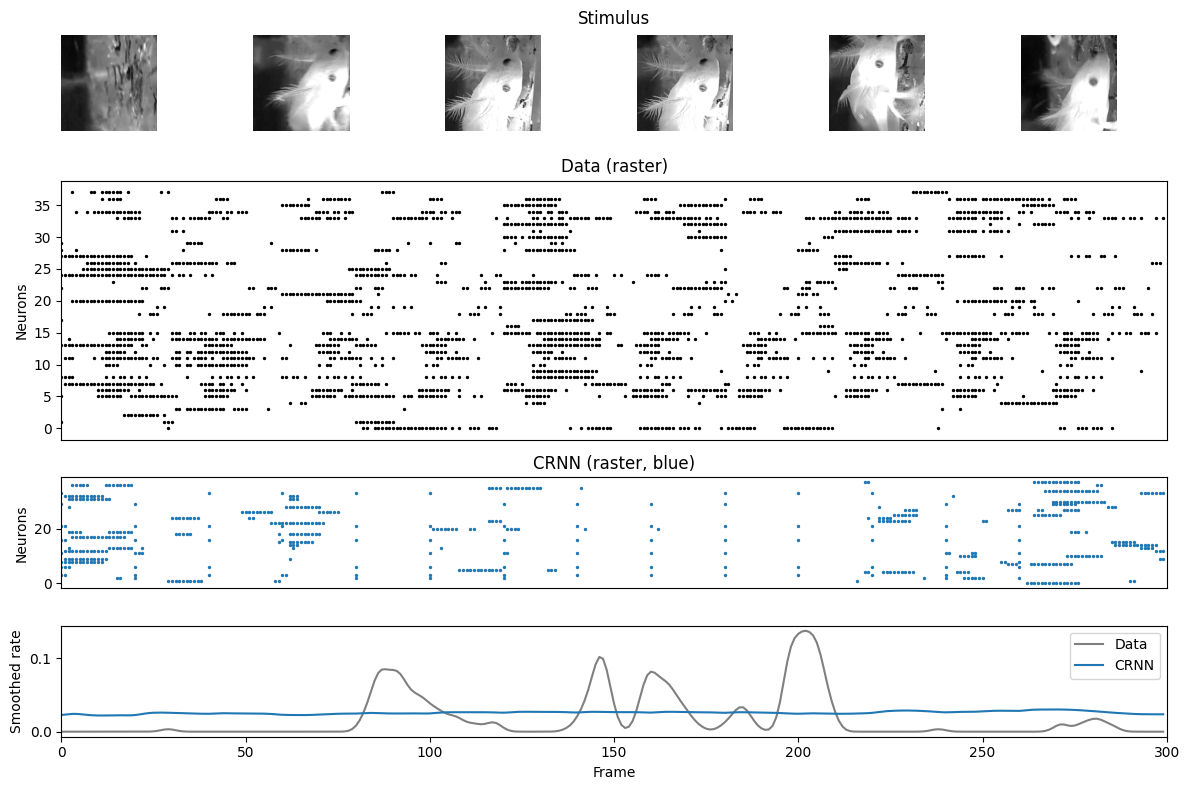

In [69]:
# Explicit plotting cell using known variables: test_frames_vis, test_responses_vis, model
import os
import numpy as np
import torch
from IPython.display import display
from plot_results import plot_rasters_and_traces

# Verify required variables exist
_required = ['test_frames_vis', 'test_responses_vis', 'model', 'test_dataset_vis']
for v in _required:
    if v not in globals():
        raise NameError(f"缺少必要变量: {v}. 请先运行数据准备/训练单元。")

# Load
test_frames = globals()['test_frames_vis']  # torch tensor (T,1,H,W)
test_responses = globals()['test_responses_vis']  # numpy (N, T)
model = globals()['model']
test_dataset = globals()['test_dataset_vis']

# Prepare arrays
T = test_frames.shape[0]
N = test_responses.shape[0]
crnn_preds = np.zeros((N, T), dtype=np.float32)
counts = np.zeros((T,), dtype=np.int32)

model.eval()
with torch.no_grad():
    # Use test_dataset.samples which are (start,end) ranges relative to test_frames start (0..T)
    for (start, end) in test_dataset.samples:
        seq = test_frames[start:end]  # (S,1,H,W)
        x = torch.tensor(seq).unsqueeze(0).to(next(model.parameters()).device)
        out = model(x)  # (1, S, N)
        out_np = out.cpu().numpy()[0]  # (S, N)
        # map
        crnn_preds[:, start:end] += out_np.T
        counts[start:end] += 1

# avoid div by zero
counts[counts == 0] = 1
crnn_preds = crnn_preds / counts[np.newaxis, :]

# Stim frames -> (T,H,W) numpy
if isinstance(test_frames, torch.Tensor):
    stim_np = test_frames.cpu().numpy()
    if stim_np.ndim == 4 and stim_np.shape[1] == 1:
        stim_np = stim_np[:, 0]
else:
    stim_np = np.array(test_frames)

# Save outputs dir
out_dir = 'outputs'
os.makedirs(out_dir, exist_ok=True)

# Plot and save
fig = plot_rasters_and_traces(
    frames=stim_np,
    data_spikes=test_responses,
    crnn_preds=crnn_preds,
    start=0,
    end=T,
    example_neuron=0,
    thumbnail_times=6
)
path = os.path.join(out_dir, 'comparison_test_full.png')
fig.savefig(path, dpi=150)
print('Saved comparison figure to', path)

# Display main figure
display(fig)